# Lab 4: Momentum II

In the last lab we explored how to backtest decile portfolio style trading strategies. In this lab we will explore how to backtest portfolios that are optimized each period to maximize alpha while minimizing variance. 

## Imports

In [1]:
import sf_quant.data as sfd
import sf_quant.optimizer as sfo
import sf_quant.backtester as sfb
import sf_quant.performance as sfp
import polars as pl
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

/home/acriddl2/Projects/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-28 18:42:17,331	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Data

We import the necessary data for you here. We will be doing a backtest from 2023-01-01 to 2024-01-31. However since our signal takes 1 year to compute, we will really only be backtesting 1 month of data.

In [2]:
start = dt.date(2023, 1, 1)
end = dt.date(2024, 1, 31)

columns = [
    'date',
    'barrid',
    'ticker',
    'price',
    'return',
    'specific_risk',
    'predicted_beta'
]

data = sfd.load_assets(
    start=start,
    end=end,
    in_universe=True,
    columns=columns
)

data

date,barrid,ticker,price,return,specific_risk,predicted_beta
date,str,str,f64,f64,f64,f64
2023-01-03,"""USA06Z1""","""MDXG""",2.97,6.8345,47.65898,1.43155
2023-01-04,"""USA06Z1""","""MDXG""",3.0,1.0101,47.539847,1.428854
2023-01-05,"""USA06Z1""","""MDXG""",3.08,2.6667,47.755957,1.37346
2023-01-06,"""USA06Z1""","""MDXG""",3.21,4.2208,48.110135,1.389274
2023-01-09,"""USA06Z1""","""MDXG""",3.28,2.1807,48.612414,1.348687
…,…,…,…,…,…,…
2024-01-25,"""USBPM41""","""WS""",29.38,-0.3054,50.968819,1.408389
2024-01-26,"""USBPM41""","""WS""",29.58,0.6807,50.922137,1.40225
2024-01-29,"""USBPM41""","""WS""",30.28,2.3665,50.93332,1.395143


## Compute the Momentum Signal

## Instructions

- Compute momentum for each security and date as the rolling 230 day return (you can just use log returns here).
- Shift the momentum signal 22 days. This will results in the 11 month return from t-12 to t-2.

In [3]:
def task_compute_momentum(data: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the t_12 to t_2 momentum signal for each security and date combination.
    
    Args:
        data (pl.DataFrame): Data frame containing date, barrid, price, and return columns.
    
    Returns:
        pl.DataFrame: Data frame with columns date, barrid, price, return, and momentum columns.
    """
    data = (
        data.clone()
        .sort(["date", "barrid"])
        .with_columns(
            (pl.col('return')/100 + 1)
            .log().rolling_sum(230).shift(22).over("barrid")
            .alias("momentum")))
    return data.drop_nulls()
pl.Config.set_tbl_rows(20)
momentum = task_compute_momentum(data)

momentum

date,barrid,ticker,price,return,specific_risk,predicted_beta,momentum
date,str,str,f64,f64,f64,f64,f64
2024-01-03,"""USA06Z1""","""MDXG""",7.775,-1.2071,49.827621,1.092049,1.027828
2024-01-03,"""USA0C11""","""FBIN""",74.15,-1.7881,17.08959,1.402901,0.195164
2024-01-03,"""USA0SY1""","""UI""",130.1,-5.1334,33.387171,1.556712,-0.876093
2024-01-03,"""USA11I1""","""EBAY""",43.55,-0.7294,19.201769,1.055038,0.012158
2024-01-03,"""USA11J1""","""ACCO""",6.26,-0.1595,34.244853,1.387209,0.019372
2024-01-03,"""USA12D1""","""ACAD""",29.57,-4.1802,42.54166,1.203095,0.33611
2024-01-03,"""USA12I1""","""LBAI""",14.28,-3.6437,15.341978,1.563223,-0.311925
2024-01-03,"""USA1441""","""ABR""",14.69,-2.2621,27.698711,1.87887,0.094177
2024-01-03,"""USA1491""","""ALNY""",190.64,-2.2008,28.724043,1.057,-0.345345


## Compute the Alphas

In order to make our momentum signal usable in our optimizer we will use a predetermined Information Coefficient of 0.05 and the forecasted idiosyncratic risk provided by Barra to convert our signal into alpha forecasts.

### Instructions
- For each date z-score the momentum signal across all assets cross sectionally and call this `score`.
- Using the `specific_risk` column compute the alphas as `0.05` * `score` * `specific_risk`.
- Note: Make sure to divide `specific_risk` by 100 to put it in decimal space. 

In [4]:
def task_compute_alphas(momentum: pl.DataFrame) -> pl.DataFrame:
    """ 
    Compute the alphas for each security and date combo.

    Args:
        momentum (pl.DataFrame): Data frame containing barrid, date, specific_risk, and momentum columns.
    
    Returns:
        pl.DataFrame: Data frame containing barrid, date, specific_risk, momentum, score, and alpha columns.
    """
    df = momentum.clone()
    df = df.with_columns(((pl.col('momentum') - pl.col('momentum').mean().over('date'))/pl.col('momentum').std().over('date')).alias('score'))
    df = df.with_columns((0.05 * pl.col('specific_risk') / 100 * pl.col('score')).alias('alpha'))
    return df

alphas = task_compute_alphas(momentum)

alphas

date,barrid,ticker,price,return,specific_risk,predicted_beta,momentum,score,alpha
date,str,str,f64,f64,f64,f64,f64,f64,f64
2024-01-03,"""USA06Z1""","""MDXG""",7.775,-1.2071,49.827621,1.092049,1.027828,2.291715,0.057095
2024-01-03,"""USA0C11""","""FBIN""",74.15,-1.7881,17.08959,1.402901,0.195164,0.503345,0.004301
2024-01-03,"""USA0SY1""","""UI""",130.1,-5.1334,33.387171,1.556712,-0.876093,-1.79747,-0.030006
2024-01-03,"""USA11I1""","""EBAY""",43.55,-0.7294,19.201769,1.055038,0.012158,0.110289,0.001059
2024-01-03,"""USA11J1""","""ACCO""",6.26,-0.1595,34.244853,1.387209,0.019372,0.125783,0.002154
2024-01-03,"""USA12D1""","""ACAD""",29.57,-4.1802,42.54166,1.203095,0.33611,0.806064,0.017146
2024-01-03,"""USA12I1""","""LBAI""",14.28,-3.6437,15.341978,1.563223,-0.311925,-0.585767,-0.004493
2024-01-03,"""USA1441""","""ABR""",14.69,-2.2621,27.698711,1.87887,0.094177,0.286447,0.003967
2024-01-03,"""USA1491""","""ALNY""",190.64,-2.2008,28.724043,1.057,-0.345345,-0.657546,-0.009444


In [5]:
def task_price_filter(alphas: pl.DataFrame) -> pl.DataFrame:
    """
    Filter the universe to lagged price greater than 5 and non-null alpha.
    
    Args:
        alphas (pl.DataFrame): Data frame containing barrid, date, specific_risk, momentum, score, and alpha columns.
    Returns:
        pl.DataFrame: Data frame containing barrid, date, specific_risk, momentum, score, and alpha columns.
    """
    df = alphas.clone()
    df = df.filter(pl.col('price').shift().over("barrid") > 5).drop_nulls(pl.col('alpha'))
    return df

price_filter = task_price_filter(alphas)

price_filter

date,barrid,ticker,price,return,specific_risk,predicted_beta,momentum,score,alpha
date,str,str,f64,f64,f64,f64,f64,f64,f64
2024-01-04,"""USA06Z1""","""MDXG""",7.76,-0.1929,49.746256,1.098982,0.989638,2.186411,0.054383
2024-01-04,"""USA0C11""","""FBIN""",74.02,-0.1753,17.07064,1.395462,0.220709,0.497264,0.004244
2024-01-04,"""USA0SY1""","""UI""",127.77,-1.7909,33.374086,1.561188,-0.820725,-1.790513,-0.029878
2024-01-04,"""USA11I1""","""EBAY""",42.53,-2.3421,19.062664,1.064649,0.013299,0.041633,0.000397
2024-01-04,"""USA11J1""","""ACCO""",6.22,-0.639,34.17139,1.383393,-0.000916,0.010407,0.000178
2024-01-04,"""USA12D1""","""ACAD""",29.95,1.2851,42.360622,1.205295,0.325556,0.727586,0.01541
2024-01-04,"""USA12I1""","""LBAI""",14.39,0.7703,15.3303,1.584716,-0.24577,-0.527477,-0.004043
2024-01-04,"""USA1441""","""ABR""",14.81,0.8169,27.655294,1.862938,0.141358,0.322948,0.004466
2024-01-04,"""USA1491""","""ALNY""",192.31,0.876,28.634186,1.048704,-0.309506,-0.667489,-0.009556


## Backtest

Now that we have our alphas we will compute the MVO portfolios for each date in our sample.

### Instructions
- Use the `FullInvestment`, `LongOnly`, `NoBuyingOnMargin`, and `UnitBeta` constraints.
- For each unique date in the `price_filter` data frame find the optimal weights using `sf_quant.optimizer.mve_optimizer`.
- Note: for the `UnitBeta` constraint to work you will need to provide the predicted betas to the optimizer in each iteration.
- Hint: the optimizer assumes that your alpha vector and covariance matrix are both sorted the same way.
- Hint: use a gamma of 10.

In [6]:
def task_backtest(price_filter: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the optimal portfolio weights for each day in our sample.
    
    Args:
        price_filter (pl.DataFrame): Data frame containing barrid, date, specific_risk, momentum, score, and alpha columns.
    Returns:
        pl.DataFrame: Data frame containing barrid, date, and weight columns.
    """
    df = price_filter.clone()
    results = []
    # weights = df.select(['date', 'barrid'])
    # weights = weights.with_columns((pl.col('barrid') + pl.Null()).alias('weight'))
    for day in df.get_column('date').sort().unique(maintain_order=True):
        dayDf = df.filter(pl.col('date') == day).sort('barrid')
        alphas = dayDf.get_column('alpha').to_numpy()
        barrids = dayDf.get_column('barrid').to_list()
        betas = dayDf.get_column('predicted_beta').to_numpy()
        cov_mat = sfd.construct_covariance_matrix(day, barrids).to_numpy()[:,1:] / 252
        results.append(sfo.mve_optimizer(barrids, alphas, cov_mat, 
                                         [sfo.FullInvestment(), sfo.LongOnly(), sfo.NoBuyingOnMargin(), sfo.UnitBeta()], 
                                         gamma=10, betas=betas).with_columns(pl.lit(day).alias('date')))
    return pl.concat(results)


weights = task_backtest(price_filter)

weights

/home/acriddl2/Projects/.venv/lib64/python3.11/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


barrid,weight,date
str,f64,date
"""USA06Z1""",-3.9294e-7,2024-01-04
"""USA0C11""",-3.4949e-7,2024-01-04
"""USA0SY1""",-3.1806e-7,2024-01-04
"""USA11I1""",-4.7273e-7,2024-01-04
"""USA11J1""",-3.7076e-7,2024-01-04
"""USA12D1""",-3.6861e-7,2024-01-04
"""USA12I1""",-3.2543e-7,2024-01-04
"""USA1441""",-2.3192e-7,2024-01-04
"""USA1491""",-4.1921e-7,2024-01-04


## Performance Analysis

Now that we have our optimal weights we will join the returns from our initial dataset. 

### Instructions
- Join the returns from `data` and compute the return and cumulative return of the portfolio using the optimal weights.
- Note: since our covariance matrix isn't lagged we will need to shift our returns forward. To do this use `.shift(-1)` by `barrid` and call it `fwd_return`.
- Chart the cumulative returns of the portfolio.

In [7]:
def task_compute_returns(weights: pl.DataFrame, data: pl.DataFrame) -> pl.DataFrame:
    """ 
    Compute the optimal portfolio returns.

    Args:
        weights (pl.DataFrame): Data frame containing barrid, date, and weight columns.
        data (pl.DataFrame): Data frame containing barrid, date, and return columns

    Returns:
        pl.DataFrame: Data frame containing date, fwd_return, and cumulative_fwd_return_columns
    """
    df = weights.join(data, on=["barrid", "date"], how="inner")
    df = df.with_columns(pl.col("return").shift(-1).alias('fwd_return'))
    df = df.with_columns((pl.col('weight') * pl.col('fwd_return')).alias('port_return_fwd'))
    returns = df.group_by("date").agg(pl.col('port_return_fwd').sum().alias('fwd_return'))
    returns = returns.sort("date").with_columns(((pl.col("fwd_return")/100).log1p().cum_sum().exp()*100).alias('cumulative_fwd_return'))
    return returns

returns = task_compute_returns(weights, data)

returns

date,fwd_return,cumulative_fwd_return
date,f64,f64
2024-01-04,0.448264,100.448264
2024-01-05,6.683634,107.161859
2024-01-08,-1.452096,105.605766
2024-01-09,-4.33115,101.031822
2024-01-10,0.683729,101.722606
2024-01-11,10.25361,112.152845
2024-01-12,-0.147745,111.987145
2024-01-16,-2.405102,109.29374
2024-01-17,2.108801,111.598528


<Axes: xlabel='date'>

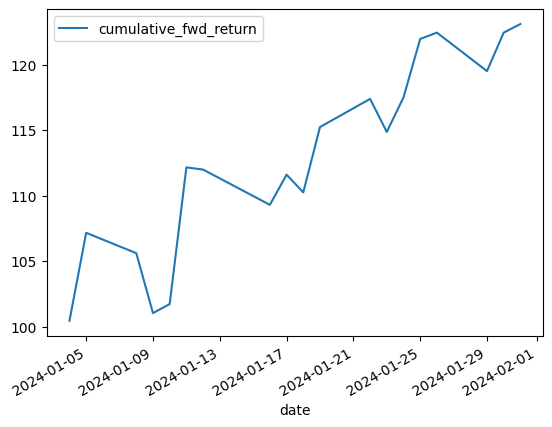

In [8]:
# TODO: Chart the cumulative returns of the portfolio.
returns.sort("date").to_pandas().set_index("date").plot(y="cumulative_fwd_return")

## Benchmark Decomposition

You should find that our portfolio is up and to the right. But the question is how much of that is due to the market being up versus our signal being good. We will find out by joining the benchmark weights to our `weights` data frame and computing the active weights.

### Instructions

- Pull in the benchmark weights using `sf_quant.data.load_benchmark`.
- Join the benchmark weights to the optimal weights.
- Compute the active weights as `weight` - `weight_bmk` = `weight_act`
- Unpivot the weight columns and compute the forward return for each portfolio (total, benchmark, and active). 

In [9]:
def task_return_decomposition(weights: pl.DataFrame, data: pl.DataFrame) -> pl.DataFrame:
    """ 
    Compute the forward returns for the total, benchmark, and active portfolios.

    Args:
        weights (pl.DataFrame): Data frame containing barrid, date, and weight columns.
        data (pl.DataFrame): Data frame containing barrid, date, and return columns

    Returns:
        pl.DataFrame: Data frame containing date, portfolio, fwd_return, and cumulative_fwd_return columns        
    """
    # TODO: Finish this function.
    benchmark = sfd.load_benchmark(weights.to_pandas().date.min(), weights.to_pandas().date.max())

    return (
        weights.join(benchmark, on=["date", "barrid"], how="left", suffix="_bmk")
            .with_columns(pl.col("weight").sub(pl.col("weight_bmk")).alias("weight_act"))
            .join(data, on=["date", "barrid"], how="left")
            .with_columns(pl.col("return").truediv(100))
            .sort("date")
            .with_columns(pl.col("return").shift(-1).over("barrid").alias("fwd_return"))
            .select(["date", "barrid", "weight", "weight_bmk", "weight_act", "fwd_return"])
            .unpivot(index=["date", "barrid", "fwd_return"], value_name="weight", variable_name="portfolio")
            .with_columns(pl.col("portfolio").replace({"weight": "Total", "weight_bmk": "Benchmark", "weight_act": "Active"}))
            .group_by(["date", "portfolio"]).agg(pl.col("fwd_return").mul(pl.col("weight")).sum())
            .sort(["date", "portfolio"])
            .with_columns(pl.col("fwd_return").add(1).cum_prod().sub(1).over("portfolio").alias("cumulative_fwd_return"))
            )

returns_decomp = task_return_decomposition(weights, data)

returns_decomp

date,portfolio,fwd_return,cumulative_fwd_return
date,str,f64,f64
2024-01-04,"""Active""",0.002781,0.002781
2024-01-04,"""Benchmark""",0.001701,0.001701
2024-01-04,"""Total""",0.004483,0.004483
2024-01-05,"""Active""",0.052221,0.055148
2024-01-05,"""Benchmark""",0.014615,0.016341
2024-01-05,"""Total""",0.066836,0.071619
2024-01-08,"""Active""",-0.012516,0.041942
2024-01-08,"""Benchmark""",-0.002005,0.014303
2024-01-08,"""Total""",-0.014521,0.056058


<Axes: xlabel='date', ylabel='cumulative_fwd_return'>

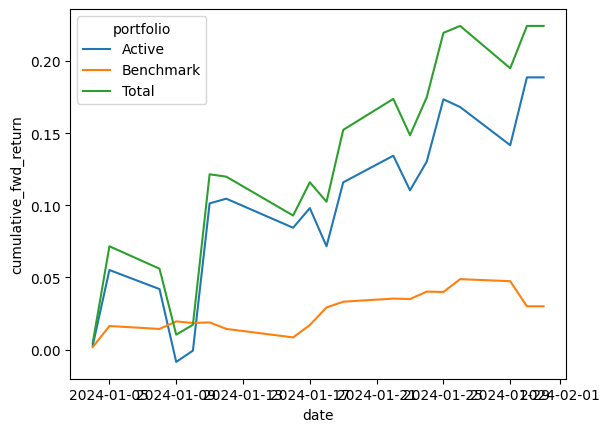

In [10]:
# TODO: Chart the cumulative returns of each portfolio
# HINT: Use seaborn.lineplot() with the attribute hue='portfolio'
sns.lineplot(data=returns_decomp.to_pandas(), x="date", y="cumulative_fwd_return", hue="portfolio")

In [11]:
# TODO: Compute the annual average return, annual volatility, and annualized sharpe ratio for each portfolio.
(returns_decomp
 .group_by("portfolio")
 .agg(
     pl.col("fwd_return").log1p().mean().mul(252).exp().sub(1).alias("annual_avg_return"),
     pl.col("fwd_return").std().mul(pl.lit(252).sqrt()).alias("annual_volatility")
 )
 .with_columns(pl.col("annual_avg_return").truediv(pl.col("annual_volatility")).alias("annualized_sharpe"))
 )

portfolio,annual_avg_return,annual_volatility,annualized_sharpe
str,f64,f64,f64
"""Benchmark""",0.480255,0.110053,4.363842
"""Active""",8.902678,0.54834,16.23569
"""Total""",13.65537,0.553817,24.656825


## `sf_quant` Backtester Module

That was a lot of fun right? Just kidding. All of that code takes a lot of work. That's why we've implemented a backtester in the `sf_quant` package. Let's practice using it really quick and compare our results.

### Instructions
- Declare your constraints the same way you did previously.
- Use a gamma of 10.
- Find the optimal weights using the `sf_quant.backtester` module.
- Hint: use the `backtest_parallel()` module to run your backtest in parallel across all the cores on your machine.

In [ ]:
def task_backtest_sf(price_filter: pl.DataFrame) -> pl.DataFrame:
    """ 
    Compute the optimal portfolio weights using the `sf_quant` package.

    Args:
        price_filter (pl.DataFrame): Data frame containing barrid, date, specific_risk, momentum, score, and alpha columns.

    Returns:
        pl.DataFrame: Data frame containing barrid, date, and weight columns.
    """
    return sfb.backtest_parallel(price_filter, [sfo.FullInvestment(), sfo.LongOnly(), sfo.NoBuyingOnMargin(), sfo.UnitBeta()], 10)

weights_sf = task_backtest_sf(price_filter)

weights_sf

2025-11-28 19:14:06,217	INFO worker.py:2012 -- Started a local Ray instance.
/home/acriddl2/Projects/.venv/lib64/python3.11/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


## `sf_quant` Performance Package

It's also not a lot of fun to merge the returns dataset and do a full decomposition manually. You can do that with `sf_quant.performance` too.

### Instructions

- Compute the portfolio forward returns decomposition using the `generate_returns_from_weights` function.
- Chart the cumulative returns of the portfolios using the `generate_returns_chart` function.
- Generate the summary table using the `generate_summary_table` function.

In [ ]:
def task_return_decomposition_sf(weights_sf: pl.DataFrame) -> pl.DataFrame:
    """ 
    Compute the returns decomposition using the `sf_quant` package.

    Args:
        weights_sf (pl.DataFrame): Data frame containing date, barrid, and weight columns.

    Returns:
        pl.DataFrame: Data frame containing date, portfolio, and return (fwd_return) columns
    """
    return sfp.generate_returns_from_weights(weights)

returns_sf = task_return_decomposition_sf(weights_sf)

returns_sf

In [ ]:
# TODO: Generate the returns chart
sfp.generate_returns_chart(returns_sf)

In [ ]:
# TODO: Generate the summary table
sfp.generate_summary_table(returns_sf)